In [12]:
import sys
# from re import split
sys.path.append('../../../')
import os
# import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from impedance.circuits import CustomCircuit
from impedance.plotting import plot_nyquist
from impedance import preprocessing

import ImpedanceCorrection as IC
%reload_ext autoreload
%autoreload 2

In [13]:
direc = r'\Data'
print(os.getcwd())
all_files=glob.glob(os.getcwd() + direc + '\*.par')
all_files.sort()

f_name=all_files[1]
print(f_name)
freqs, Z= preprocessing.readVersaStudio(f_name)

C:\Users\shadd\OneDrive\Documents\Python\EIS
C:\Users\shadd\OneDrive\Documents\Python\EIS\Data\LSC_DPB1_FRXAS_700C_1%_EIS_OCV_before2.par


First, a simulated example with a somewhat representative circuit

In [14]:
print(10**-5)
np.log10(1e-5)

1e-05


-5.0

In [130]:
(1**.994035)

1.0

Simulating circuit based on initial parameters
Simulating circuit based on initial parameters
Yes array
Capacitance that minimizes LY is:  0.0008235530295828552


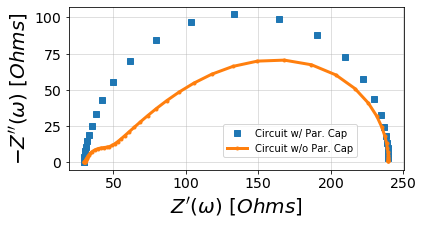

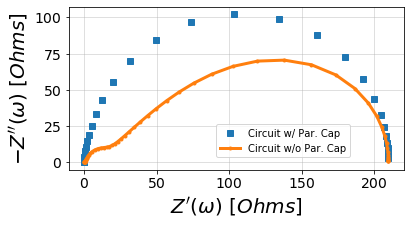

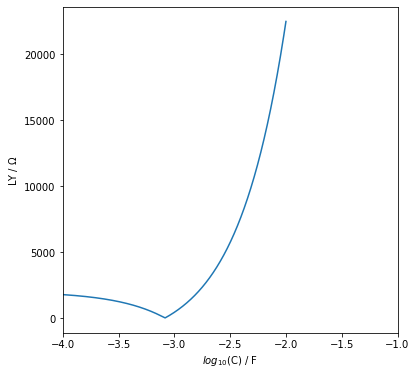

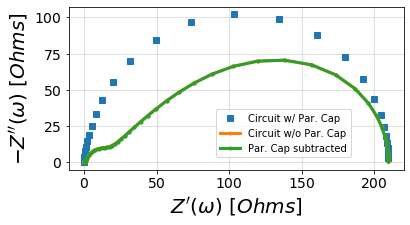

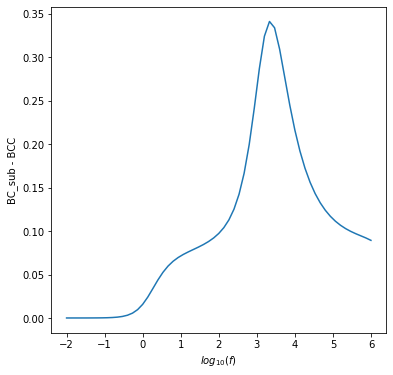

In [15]:
R_elyte = 30

circ = 'R1-p(E1,p(R2,C2)-G1)'
circCorr = 'R1-p(R2,C2)-G1)'

vals = [R_elyte, 8.233e-4, 1, 10, 1e-5, 200, .1]
valsCorr = [R_elyte, 10, 1e-5, 200, .1]


pred_freq = np.logspace(np.log10(1e6), np.log10(1e-2), num = freqs.size)

BertCirc = CustomCircuit(circ, initial_guess = vals)
BC_pred = BertCirc.predict(pred_freq)

BertCircCorr = CustomCircuit(circCorr, initial_guess = valsCorr)
BCC_pred = BertCircCorr.predict(pred_freq)

C_guess=np.logspace(-5,-2, num = 10000)

fig = plt.figure(figsize=(6,6))
ax0 = fig.add_subplot(111)
plot_nyquist(ax0, pred_freq, BC_pred,fmt='s')
plot_nyquist(ax0, pred_freq, BCC_pred)
fig.legend(labels=('Circuit w/ Par. Cap', 'Circuit w/o Par. Cap'), loc=(0.525,0.3))
# fig.savefig('Figures\Initial_BerthierCircuit.png', dpi=300, bbox_inches='tight')

fig = plt.figure(figsize=(6,6))
ax0 = fig.add_subplot(111)
plot_nyquist(ax0, pred_freq, BC_pred-R_elyte,fmt='s')
plot_nyquist(ax0, pred_freq, BCC_pred-R_elyte)
fig.legend(labels=('Circuit w/ Par. Cap', 'Circuit w/o Par. Cap'), loc=(0.525,0.3))
# fig.savefig('Figures\OhmicCorrected_BerthierCircuit.png', dpi=300, bbox_inches='tight')


BC_LY = IC.calcLY(C_guess, pred_freq, BC_pred-R_elyte)

fig = plt.figure(figsize=(6,6))
ax0 = fig.add_subplot(111)
plt.plot(np.log10(C_guess), BC_LY)
# ax0.set_ylim((0,10))
ax0.set_xlim((-4.001,-1))
ax0.set_ylabel('LY / $\Omega$')
ax0.set_xlabel('$log_{10}$(C) / F')
# fig.savefig('Figures\Correction_Function.png', dpi=300, bbox_inches='tight')

C_sub = C_guess[np.argmin(BC_LY)]
print('Capacitance that minimizes LY is: ', C_sub)

BC_sub = IC.par_cap_subtract(C_sub, pred_freq, BC_pred-R_elyte)

fig = plt.figure(figsize=(6,6))
ax0 = fig.add_subplot(111)
plot_nyquist(ax0, pred_freq, BC_pred-R_elyte,fmt='s')
plot_nyquist(ax0, pred_freq, BCC_pred-R_elyte)
plot_nyquist(ax0, pred_freq, BC_sub)
fig.legend(labels=('Circuit w/ Par. Cap', 'Circuit w/o Par. Cap', 'Par. Cap subtracted'), loc=(0.525,.3))
# fig.savefig('Figures\Corrected_BerthierCircuit.png', dpi=300, bbox_inches='tight')

fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
plt.plot(np.log10(pred_freq), np.abs(BC_sub)-np.abs(BCC_pred-R_elyte))
ax1.set_ylabel('BC_sub - BCC')
ax1.set_xlabel('$log_{10}(f)$')
# fig.savefig('Figures\Correction_Error.png', dpi=300, bbox_inches='tight')
plt.show()

Now, trying to use some real data from the July 2018 trip

Yes array
Capacitance that minimizes LY is:  1.4352107926607617e-06


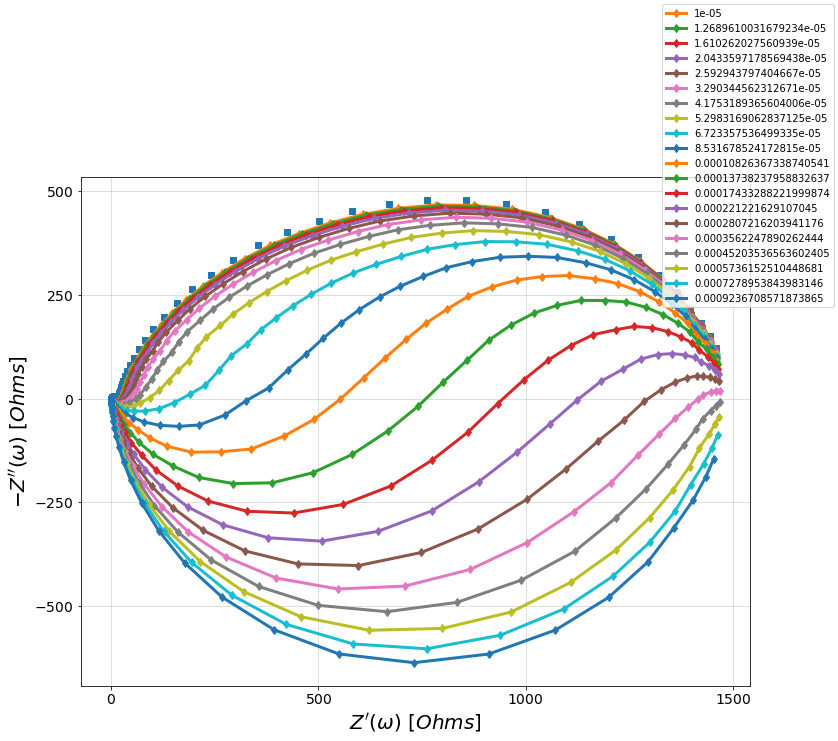

In [16]:
f0, Z0 = preprocessing.readVersaStudio(all_files[1])

f, Z = preprocessing.ignoreBelowX(f0, Z0)

Z = Z - Z[0]

#Just plotting data
# fig=plt.figure(figsize = (6, 6))
# ax0=fig.add_subplot(111)
# plot_nyquist(ax0, f, Z, fmt='s')
# fig.savefig('Figures\Initial_RealData.png', dpi=300, bbox_inches = 'tight')

#Calculating and plotting LY
C_guess =np.logspace(-7,-4, num = 10000)
LY1=IC.calcLY(C_guess, f[1:], Z[1:])

# fig = plt.figure(figsize = (6,6))
# ax0 = fig.add_subplot(111)
# plt.plot(np.log10(C_guess), LY1)
# # ax0.set_ylim((0, 10))
# # ax0.set_xlim((-4.001,-3))
# ax0.set_ylabel('LY / $\Omega$')
# ax0.set_xlabel('$log_{10}$(C) / F')
# fig.savefig('Figures\Correction_Fucntion_RealData.png', dpi=300, bbox_inches = 'tight')

C_sub = C_guess[np.argmin(LY1)]
print('Capacitance that minimizes LY is: ', C_sub)

Z_corr = []
C_subs = np.logspace(-5,-2, num = 30)

for i in range(20):
    Z_corr.append(IC.par_cap_subtract(C_subs[i], f[1:], Z[1:]))


# Z_corr = IC.par_cap_subtract(C_sub, f[1:], Z[1:])
fig=plt.figure(figsize = (12, 12))
ax0=fig.add_subplot(111)
plot_nyquist(ax0, f, Z, fmt = 's')
for i in range(20):
    
    plot_nyquist(ax0, f, Z_corr[i], fmt = '-d', label=str(C_subs[i]))
    
fig.legend()
# fig.legend(labels = ('Initial Impedance', 'Corrected Impedance'), loc = 'center')
# fig.savefig('Figures\CorrectedZ_RealData.png', dpi=300, bbox_inches = 'tight')
plt.show()

Doesn't work very well... Maybe we need to adjust the elements being removed with Berthier subtraction to include a resistor, too.

In [17]:
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy import optimize

 active_mask: array([0.])
        cost: 0.32381287062620034
         fun: array([0.80475197])
        grad: array([43739.64908689])
         jac: array([[54351.71387726]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 30
        njev: 19
  optimality: 43739.64908688768
      status: 3
     success: True
           x: array([0.0008236])
 active_mask: array([0., 0.])
        cost: 0.31786770347216675
         fun: array([0.79733017])
        grad: array([77483.35330751,  2963.04806556])
         jac: array([[97178.50371052,  3716.21212999]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 24
        njev: 8
  optimality: 77483.35330751202
      status: 3
     success: True
           x: array([8.23638072e-04, 9.99997617e-01])


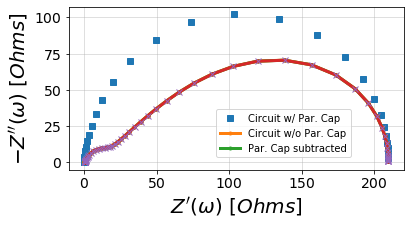

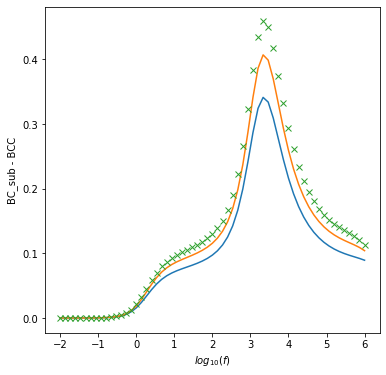

In [18]:
C0 = 1e-8
CPE0 = np.array([1e-8,1])

resC = least_squares(IC.Par_Cap_Res, C0, method= 'trf', args=(pred_freq, BC_pred-R_elyte), max_nfev=2000)
print(resC)

resCPE = least_squares(IC.Par_CPE_Res, CPE0, method= 'trf', args=(pred_freq, BC_pred-R_elyte), max_nfev=2000)
print(resCPE)

BC_sub2 = IC.par_cap_subtract(resC.x[0], pred_freq, BC_pred-R_elyte)
BC_sub3 = IC.par_cap_subtract(resCPE.x[0], pred_freq, BC_pred-R_elyte)

fig = plt.figure(figsize=(6,6))
ax0 = fig.add_subplot(111)
plot_nyquist(ax0, pred_freq, BC_pred-R_elyte,fmt='s')
plot_nyquist(ax0, pred_freq, BCC_pred-R_elyte)
plot_nyquist(ax0, pred_freq, BC_sub)
plot_nyquist(ax0, pred_freq, BC_sub2)
plot_nyquist(ax0, pred_freq, BC_sub3,fmt='x')
fig.legend(labels=('Circuit w/ Par. Cap', 'Circuit w/o Par. Cap', 'Par. Cap subtracted'), loc=(0.525,.3))
# fig.savefig('Figures\Corrected_BerthierCircuit.png', dpi=300, bbox_inches='tight')

fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
plt.plot(np.log10(pred_freq), np.abs(BC_sub)-np.abs(BCC_pred-R_elyte))
plt.plot(np.log10(pred_freq), np.abs(BC_sub2)-np.abs(BCC_pred-R_elyte))
plt.plot(np.log10(pred_freq), np.abs(BC_sub3)-np.abs(BCC_pred-R_elyte),'x')
ax1.set_ylabel('BC_sub - BCC')
ax1.set_xlabel('$log_{10}(f)$')
# fig.savefig('Figures\Correction_Error.png', dpi=300, bbox_inches='tight')
plt.show()

 active_mask: array([0.])
        cost: 0.0067752116381803165
         fun: array([0.11640629])
        grad: array([15.6120979])
         jac: array([[134.11731034]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 23
        njev: 6
  optimality: 15.612097902121194
      status: 3
     success: True
           x: array([1.4296875e-06])
 active_mask: array([0., 0.])
        cost: 0.0057731113982071635
         fun: array([0.10745335])
        grad: array([3.8031034 , 0.00955285])
         jac: array([[35.39306443,  0.08890229]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 25
        njev: 9
  optimality: 3.8031034006345226
      status: 3
     success: True
           x: array([4.26962897e-06, 9.19999907e-01])


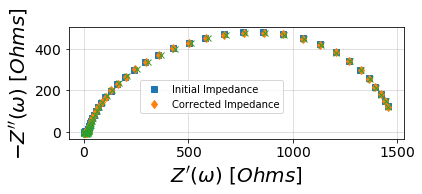

In [102]:
C0=1e-6
CPE0=np.array([1e-4,.92])

resC = least_squares(IC.Par_Cap_Res, C0, method= 'trf', args=(f[1:], Z[1:]), max_nfev=2000)
print(resC)

resCPE = least_squares(IC.Par_CPE_Res, CPE0, method= 'trf', args=(f[1:], Z[1:]), max_nfev=2000)
print(resCPE)

Z_corrC = IC.par_cap_subtract(resC.x[0], f[1:], Z[1:])
Z_corrCPE = IC.par_cap_subtract(resCPE.x[0], f[1:], Z[1:])

fig=plt.figure(figsize = (6, 6))
ax0=fig.add_subplot(111)
plot_nyquist(ax0, f, Z, fmt = 's')
plot_nyquist(ax0, f, Z_corrC, fmt = 'd')
plot_nyquist(ax0, f, Z_corrCPE, fmt = 'x')
fig.legend(labels = ('Initial Impedance', 'Corrected Impedance'), loc = 'center')
# fig.savefig('Figures\CorrectedZ_RealData.png', dpi=300, bbox_inches = 'tight')
plt.show()

In [20]:
1 / resRC.x[0]

0.00014285714285714287

Simulating circuit based on initial parameters
Simulating circuit based on initial parameters
 active_mask: array([0., 0.])
        cost: 714.5510256622434
         fun: array([37.80346613])
        grad: array([       0.        , 92677873.73420852])
         jac: array([[      0.        , 2451570.80092382]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 16
        njev: 2
  optimality: 92677873.73420852
      status: 3
     success: True
           x: array([7.00000000e+03, 3.39011417e-04])


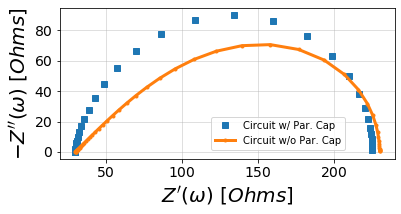

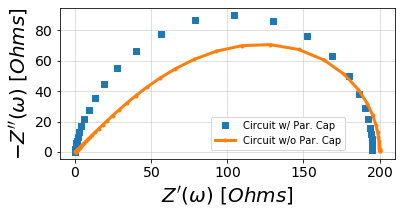

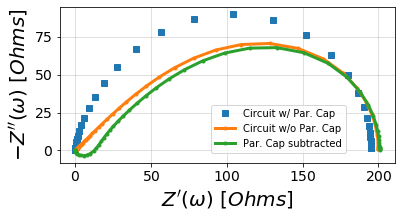

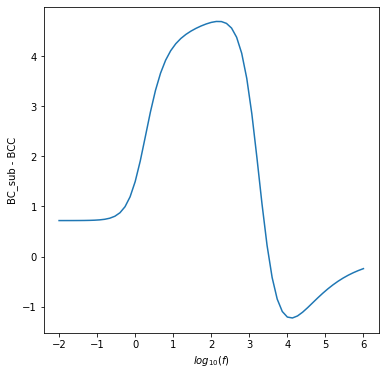

In [103]:
R_elyte = 30

circ = 'R1-p(C1,R3,G1)'
circCorr = 'R1-G1)'

vals = [R_elyte, 3.233e-4, 8000, 200, .1]
valsCorr = [R_elyte, 200, .1]


pred_freq = np.logspace(np.log10(1e6), np.log10(1e-2), num = freqs.size)

BertCirc = CustomCircuit(circ, initial_guess = vals)
BC_pred = BertCirc.predict(pred_freq)

BertCircCorr = CustomCircuit(circCorr, initial_guess = valsCorr)
BCC_pred = BertCircCorr.predict(pred_freq)

fig = plt.figure(figsize=(6,6))
ax0 = fig.add_subplot(111)
plot_nyquist(ax0, pred_freq, BC_pred,fmt='s')
plot_nyquist(ax0, pred_freq, BCC_pred)
fig.legend(labels=('Circuit w/ Par. Cap', 'Circuit w/o Par. Cap'), loc=(0.525,0.3))
# fig.savefig('Figures\Initial_BerthierCircuit.png', dpi=300, bbox_inches='tight')

fig = plt.figure(figsize=(6,6))
ax0 = fig.add_subplot(111)
plot_nyquist(ax0, pred_freq, BC_pred-R_elyte,fmt='s')
plot_nyquist(ax0, pred_freq, BCC_pred-R_elyte)
fig.legend(labels=('Circuit w/ Par. Cap', 'Circuit w/o Par. Cap'), loc=(0.525,0.3))
# fig.savefig('Figures\OhmicCorrected_BerthierCircuit.png', dpi=300, bbox_inches='tight')


RC0 = np.array([7000, 1e-8])

resRC= least_squares(IC.Par_RC_Res, RC0, method= 'trf', args=(pred_freq, BC_pred-R_elyte), max_nfev=2000)
resRC= least_squares(IC.Par_RC_Res, resRC.x, method= 'trf', args=(pred_freq, BC_pred-R_elyte), max_nfev=2000)
print(resRC)

BC_sub = IC.par_RC_subtract(resRC.x, pred_freq, BC_pred-R_elyte)


fig = plt.figure(figsize=(6,6))
ax0 = fig.add_subplot(111)
plot_nyquist(ax0, pred_freq, BC_pred-R_elyte,fmt='s')
plot_nyquist(ax0, pred_freq, BCC_pred-R_elyte)
plot_nyquist(ax0, pred_freq, BC_sub)
fig.legend(labels=('Circuit w/ Par. Cap', 'Circuit w/o Par. Cap', 'Par. Cap subtracted'), loc=(0.525,.3))
# fig.savefig('Figures\Corrected_BerthierCircuit.png', dpi=300, bbox_inches='tight')

fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
plt.plot(np.log10(pred_freq), np.abs(BC_sub)-np.abs(BCC_pred-R_elyte))
ax1.set_ylabel('BC_sub - BCC')
ax1.set_xlabel('$log_{10}(f)$')
# fig.savefig('Figures\Correction_Error.png', dpi=300, bbox_inches='tight')
plt.show()

In [22]:
from scipy.optimize import brute

In [30]:
np.logspace(2,3,num=11, endpoint=True)

array([ 100.        ,  125.89254118,  158.48931925,  199.5262315 ,
        251.18864315,  316.22776602,  398.10717055,  501.18723363,
        630.95734448,  794.32823472, 1000.        ])

In [41]:
a = slice(1e-2,1, .1)
a

slice(0.01, 1, 0.1)

In [150]:
10**-3.1

0.0007943282347242813

In [161]:
10**-3.2

0.000630957344480193

In [165]:
CPE0 = np.array([7.94328e-4, .98])
rrange = ((6.3095e-4, 1e-3), (.97, 1))

d_st = 3e-16
x_t = xtol=3e-16
f_t = ftol=3e-16
g_t = gtol=3e-16

In [225]:
resCPEin = least_squares(IC.Par_CPE_Res, CPE0, method= 'trf', loss='soft_l1', args=(pred_freq, BC_pred-R_elyte), max_nfev=2000)

bruteout20 = brute(IC.Par_CPE_Res, rrange, Ns=20, args=(pred_freq, BC_pred-R_elyte), full_output=True, finish=optimize.fmin, workers=-1)
bruteout100 = brute(IC.Par_CPE_Res, rrange, Ns=100, args=(pred_freq, BC_pred-R_elyte), full_output=True, finish=optimize.fmin, workers=-1)

resCPEout = least_squares(IC.Par_CPE_Res, bruteout100[0], method= 'trf', loss='soft_l1', args=(pred_freq, BC_pred-R_elyte), max_nfev=2000, diff_step=d_st, xtol=x_t, ftol=f_t, gtol=g_t)

LS_only = IC.par_CPE_subtract(resCPEin.x, pred_freq, BC_pred-R_elyte)
Bru100_only = IC.par_CPE_subtract(bruteout100[0], pred_freq, BC_pred-R_elyte)
LS_Bru100 = IC.par_CPE_subtract(resCPEout.x, pred_freq, BC_pred-R_elyte)

print(resCPEin, bruteout100[0], resCPEout)

 active_mask: array([0., 0.])
        cost: 24.396300849409887
         fun: array([25.37660531])
        grad: array([ -604.94143748, -1317.68938845])
         jac: array([[ -4.73036418, -10.30372578]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 36
        njev: 19
  optimality: 1317.689388454927
      status: 3
     success: True
           x: array([4.46767625e-04, 9.79996382e-01]) [3.26683317e-04 9.99412153e-01]  active_mask: array([0., 0.])
        cost: 0.03587825883513429
         fun: array([0.2702661])
        grad: array([10.81413243, 41.87529699])
         jac: array([[ 39.31386509, 152.23410543]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 33
        njev: 11
  optimality: 41.87529699396478
      status: 3
     success: True
           x: array([3.26684646e-04, 9.99412153e-01])


In [167]:
bruteout1000 = brute(IC.Par_CPE_Res, rrange, Ns=1000, args=(pred_freq, BC_pred-R_elyte), full_output=True, finish=optimize.fmin, workers=-1)

In [226]:
Bru1000_only = IC.par_CPE_subtract(bruteout1000[0], pred_freq, BC_pred-R_elyte)

In [228]:
resCPEout2 = least_squares(IC.Par_CPE_Res, bruteout1000[0], method= 'trf', loss='soft_l1', args=(pred_freq, BC_pred-R_elyte), max_nfev=2000, diff_step=d_st, xtol=x_t, ftol=f_t, gtol=g_t)
LS_Bru1000 = IC.par_CPE_subtract(resCPEout2.x, pred_freq, BC_pred-R_elyte)
print(resCPEout2)

 active_mask: array([0., 0.])
        cost: 0.03587825883513429
         fun: array([0.2702661])
        grad: array([10.81413243, 41.87529699])
         jac: array([[ 39.31386509, 152.23410543]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 33
        njev: 11
  optimality: 41.87529699396478
      status: 3
     success: True
           x: array([3.26684646e-04, 9.99412153e-01])


In [212]:
BC_sub4 = IC.par_CPE_subtract(resCPEout.x, pred_freq, BC_pred-R_elyte)

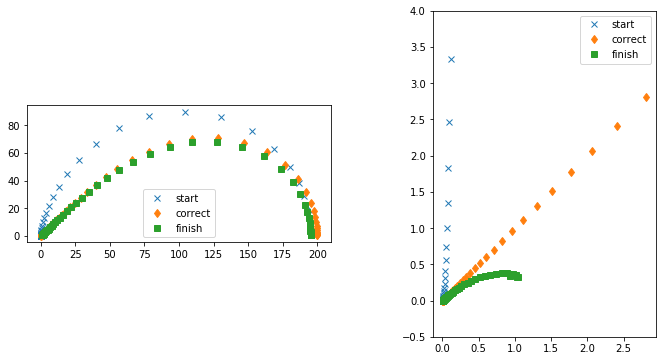

In [222]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
Yel1 = 1/(BC_pred-R_elyte)
Yel2 = 1/(BCC_pred-R_elyte)
Yel3 = 1/BC_sub4

ax1.plot(np.real(BC_pred-R_elyte), -np.imag(BC_pred-R_elyte), 'x', label='start')
ax1.plot(np.real(BCC_pred-R_elyte), -np.imag(BCC_pred-R_elyte), 'd', label='correct')
ax1.plot(np.real(BC_sub4), -np.imag(BC_sub4), 's', label='finish')
ax1.set_aspect('equal')
ax1.legend()


ax2.plot(np.real(Yel1), np.imag(Yel1), 'x', label='start')
ax2.plot(np.real(Yel2), np.imag(Yel2), 'd', label='correct')
ax2.plot(np.real(Yel3), np.imag(Yel3), 's', label='finish')
ax2.set_aspect('equal')
ax2.legend()

ax2.set_ylim(-.5,4)

plt.show()

In [187]:
bruteout100

(array([-3.48586194,  0.99941056]),
 0.2702697767796379,
 array([[[-3.        , -3.        , -3.        , ..., -3.        ,
          -3.        , -3.        ],
         [-3.0020202 , -3.0020202 , -3.0020202 , ..., -3.0020202 ,
          -3.0020202 , -3.0020202 ],
         [-3.0040404 , -3.0040404 , -3.0040404 , ..., -3.0040404 ,
          -3.0040404 , -3.0040404 ],
         ...,
         [-3.1959596 , -3.1959596 , -3.1959596 , ..., -3.1959596 ,
          -3.1959596 , -3.1959596 ],
         [-3.1979798 , -3.1979798 , -3.1979798 , ..., -3.1979798 ,
          -3.1979798 , -3.1979798 ],
         [-3.2       , -3.2       , -3.2       , ..., -3.2       ,
          -3.2       , -3.2       ]],
 
        [[ 0.97      ,  0.97030303,  0.97060606, ...,  0.99939394,
           0.99969697,  1.        ],
         [ 0.97      ,  0.97030303,  0.97060606, ...,  0.99939394,
           0.99969697,  1.        ],
         [ 0.97      ,  0.97030303,  0.97060606, ...,  0.99939394,
           0.99969697,  1. 

In [186]:
CPE0_log = np.array([-3.1, .98])
rrange_log = ((-3, -3.2), (.97, 1))
resCPE_login = least_squares(IC.Par_CPE_Res_log, CPE0_log, method= 'dogbox', loss='soft_l1', args=(pred_freq, BC_pred-R_elyte), max_nfev=2000)

bruteout20 = brute(IC.Par_CPE_Res_log, rrange_log, Ns=20, args=(pred_freq, BC_pred-R_elyte), full_output=True, finish=optimize.fmin, workers=-1)
rrange_log_20 = ((bruteout20[0][0] * .9, bruteout20[0][0] * 1.1), (bruteout20[0][1] * .9, bruteout20[0][1] *1.1))
bruteout100 = brute(IC.Par_CPE_Res_log, rrange_log, Ns=100, args=(pred_freq, BC_pred-R_elyte), full_output=True, workers=-1)

resCPE_logout = least_squares(IC.Par_CPE_Res_log, bruteout100[0], method= 'dogbox', loss='soft_l1', args=(pred_freq, BC_pred-R_elyte), max_nfev=2000, diff_step=d_st, xtol=x_t, ftol=f_t, gtol=g_t)

print(resCPE_login, bruteout100[0], resCPE_logout)

 active_mask: array([0, 0])
        cost: 29.89152576511207
         fun: array([30.87533585])
        grad: array([ 142.0673642 , -310.26165787])
         jac: array([[ 0.82787154, -1.80799298]])
     message: 'The maximum number of function evaluations is exceeded.'
        nfev: 2000
        njev: 1961
  optimality: 310.26165786856706
      status: 0
     success: False
           x: array([-3.31969839,  0.97586322]) [-3.48586194  0.99941056]  active_mask: array([0, 0])
        cost: 0.03587921701350649
         fun: array([0.27026978])
        grad: array([-6.60424846,  3.65272014])
         jac: array([[-24.00885014,  13.27896897]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 24
        njev: 1
  optimality: 6.6042484609915535
      status: 3
     success: True
           x: array([-3.48586194,  0.99941056])


In [180]:
resCPE_login.x * 1.1

array([-3.65166823,  1.07344954])

In [ ]:
CPE0_log = np.array([-3.1, .98])

resCPE_login = least_squares(IC.Par_CPE_Res_log, CPE0_log, method= 'dogbox', loss='soft_l1', args=(pred_freq, BC_pred-R_elyte), max_nfev=2000)


rrange_log = ((-3.2, -3), (.97, 1))
bruteout20 = brute(IC.Par_CPE_Res_log, rrange_log, Ns=20, args=(pred_freq, BC_pred-R_elyte), full_output=True, finish=optimize.fmin, workers=-1)
rrange_log_20 = ((bruteout20[0][0] * .9, bruteout20[0][0] * 1.1), (bruteout20[0][1] * .9, bruteout20[0][1] *1.1))
bruteout100 = brute(IC.Par_CPE_Res_log, rrange_log_20, Ns=100, args=(pred_freq, BC_pred-R_elyte), full_output=True, finish=optimize.fmin, workers=-1)

resCPE_logout = least_squares(IC.Par_CPE_Res_log, bruteout100[0], method= 'dogbox', loss='soft_l1', args=(pred_freq, BC_pred-R_elyte), max_nfev=2000, diff_step=d_st, xtol=x_t, ftol=f_t, gtol=g_t)

print(resCPE_login, bruteout100[0], resCPE_logout)